In [1]:
import tensorflow as tf
from tensorflow.python.keras import Input
from tensorflow.python.keras.engine.functional import Functional
from tensorflow.python.keras.engine.keras_tensor import KerasTensor
from tensorflow.python.keras.models import Model, Sequential

import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Lambda

from tensorflow.python.keras.regularizers import l2
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()

import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False


## Import the MNIST data class and call it.

Original dataset and modified dataset with half resolution is shown below.

(10000, 784)


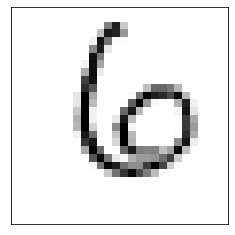

In [2]:
import MNIST_dataset as mnist
data = mnist.MNISTData()
print(data.x_test.shape)

ax = plt.subplot()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(data.x_test[100].reshape(28,28), cmap='gray_r')

(10000, 196)


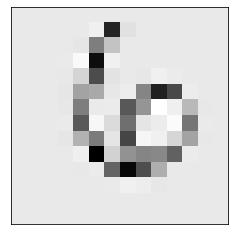

In [30]:
data_zoom = mnist.MNISTData(zoom_factor=1/2)
test = data_zoom.x_test
print(test.shape)
ax = plt.subplot()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(test[100].reshape(14,14), cmap='gray_r')

# Variational Autoencoder using Keras
The aim of this class is to implement the variational autoencoder and to test it on the MNIST dataset and then build a variational autoencoder that is able to classify MNIST data in its latent dimension with gaussian noise applied to the orignal images.

Code partially adapted from [Keras Documentation](https://keras.io/examples/generative/vae/).

In [37]:
class VAE:
    """Variational Autencoder Class"""
    def __init__(self, data: mnist.MNISTData, num_classes=10):
        self.x_train = data.x_train
        self.x_test = data.x_test
        self.y_train = data.y_train
        self.y_test = data.y_test

        self.num_classes = num_classes
        self.input_shape = self.x_train[0].shape
        self.input = Input(shape=self.input_shape, name='encoder_input')
        self.latent_dim = 2

        self.encoder = None
        self.encoder_model = None

        self.decoder = None
        self.VAE = None
        self.encoded_mean = None
        self.encoded_var = None
        self.decoder_model=None
        
    def build_encoder(self):
        """Building the encoder architecture for the variational autoencoder. 
        The final encoding dimension is 2. 
        """
        
        self.encoder = Dense(49,  activation='relu')(self.input)
        self.encoder = Dense(16, activation='relu')(self.encoder)
        self.encoder = Dense(8, activation='relu')(self.encoder)
        

        self.encoded_mean = Dense(self.latent_dim)(self.encoder)
        self.encoded_var = Dense(self.latent_dim)(self.encoder)
        self.encoder = Lambda(self.sampling, output_shape=(self.latent_dim,), name = 'encoder_output')([self.encoded_mean, self.encoded_var])

        #building a model for the encoder in order to be able to predict and plot the latent dimension
        self.encoder_model = Model(self.input, [self.encoded_mean, self.encoded_var, self.encoder], name='encoder')
    
    def build_decoder(self):
        """Building the decoder architecture and storing the output in self.decoder."""
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the decoder!")        
        self.decoder = Dense(8, activation='relu')(self.encoder)
        self.decoder = Dense(16, activation='relu')(self.decoder)
        self.decoder = Dense(49, activation='relu')(self.decoder)
        self.decoder = Dense(196,activation='sigmoid', name='ecoder_output')(self.decoder)
        
    def build_classifier(self):
        """ Building the classifier architecture, using self.encoder as input."""

        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the classifier!")
        if self.decoder is None:
            raise RuntimeError("The decoder has to be built before you can build the autoencoder!")
        self.latent_classifier = Dense(50, activation='relu')(self.encoder)
        self.latent_classifier = Dense(40, activation='relu')(self.latent_classifier)
        self.latent_classifier = Dense(30, activation='relu')(self.latent_classifier)
        self.latent_classifier = Dense(20, activation='relu')(self.latent_classifier)

        self.latent_classifier = Dense(self.num_classes, activation='softmax',name='classifier_output')(self.latent_classifier)
       
    def build_vae(self, use_latent_classifier=False):
        """ Building the whole variational autoencoder Model from self.encoder and self.decoder with 
        self.input as input. It is used self.custom_loss as the model loss function.
        """
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the autoencoder!")
        if self.decoder is None:
            raise RuntimeError("The decoder has to be built before you can build the autoencoder!")

        if use_latent_classifier:
            if self.latent_classifier is None:
                raise RuntimeError("If you want to use the option with the latent classifier, you have to build it "
                                   "beforehand!")
            self.VAE = Model(self.input, outputs=[self.decoder, self.latent_classifier])
            self.VAE.compile(loss=self.custom_loss(self.encoded_mean, self.encoded_var), loss_weights=[1, 0.1], optimizer='adam')#, metrics="accuracy")
        else:
            self.VAE = Model(self.input, outputs=self.decoder)
            self.VAE.compile(optimizer='adam', loss=self.custom_loss(self.encoded_mean, self.encoded_var))
        
        self.VAE.summary()

    def sampling(self, args):
        """ Implement the Reparameterization trick. The function returns
         a vector randomly sampled from the latent space.
         # Arguments
        args (tensor): mean and log of variance of Q(z|X)
         # Returns
            z (tensor): sampled latent vector   
        """
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # we apply the multigaussian noise to every points at once
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    

    def custom_loss(self, mean, var):
        """Implement the loss function for the variational autoencoder.
        Sort of recepy for tf to how to compute loss function from two values."""
        
        def loss(y_true, y_pred):

            reconstruction_loss = tf.losses.mean_squared_error(y_true, y_pred)*784
            kl_loss = 1. + var - K.square(mean) - K.exp(var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5
            beta = 1.0*10**-2
            return K.mean(reconstruction_loss + beta*kl_loss)

        return loss
        
        
    def fit_data(self, batch_size=128, epochs=40, use_latent_classifier=False):
        """Write the fit function for the autoencoder. 
        Store the fit history in self.history to be able to plot the fitting scores."""
        
        if use_latent_classifier:
            self.history = self.VAE.fit(self.x_train, [self.x_train, self.y_train],
                                                validation_data=(self.x_test, [self.x_test, self.y_test]),
                                                batch_size=batch_size, epochs=epochs,
                                                shuffle=True,
                                                )
        else:
            self.history = self.VAE.fit(self.x_train, self.x_train, validation_data=(self.x_test, self.x_test),
                                                batch_size=batch_size, epochs=epochs,
                                                shuffle=True,
                                                )
        
        self.history = self.history.history

    def dir(self):
        """Creation of the directories"""
        dir = os.path.join("images")
        if not os.path.exists(dir):
            os.mkdir(dir)
        dir2 = os.path.join("./images/VAE")
        if not os.path.exists(dir2):
            os.mkdir(dir2)
    
    def plot_score(self, model_name=None):
        """Plots the scores achieved during the fitting."""
        plt.plot(self.history['loss'])
        plt.plot(self.history['val_loss'])
        plt.ylabel('Model Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='best')
        plt.title('Accuracy of {model_name}'.format(model_name=model_name))
        
        plt.savefig('./images/VAE/Accuracy of {model_name}.png'.format(model_name=model_name))
        plt.show()

    def plot_latent_dimension(self, model_name=None):
        """Plots the latent dimension of the autoencoder."""
        prediction = self.encoder_model.predict(self.x_test)
        fig = plt.figure(figsize=(10, 10))
        fig.patch.set_facecolor("white")
        plt.scatter(prediction[2][:, 0], prediction[2][:, 1], c=np.argmax(self.y_test, axis=1) , cmap="Set3")
        plt.colorbar()
        plt.title('Latent space {model_name}'.format(model_name=model_name))
        
        plt.savefig('./images/VAE/Latent dimension of {model_name}.png'.format(model_name=model_name))

        plt.show()  

Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 196)]        0                                            
__________________________________________________________________________________________________
dense_125 (Dense)               (None, 49)           9653        encoder_input[0][0]              
__________________________________________________________________________________________________
dense_126 (Dense)               (None, 16)           800         dense_125[0][0]                  
__________________________________________________________________________________________________
dense_127 (Dense)               (None, 8)            136         dense_126[0][0]                  
______________________________________________________________________________________

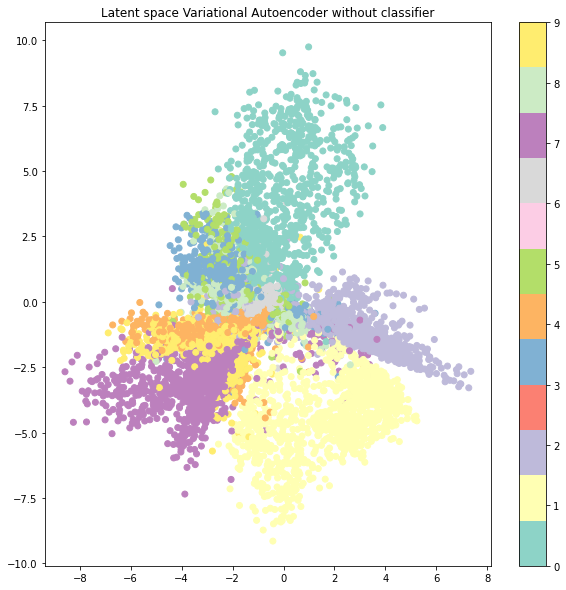

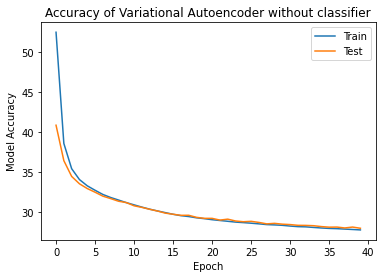

In [38]:
network = VAE(data_zoom)
network.build_encoder()
network.build_decoder()
network.build_vae()
network.fit_data()
network.dir()
network.plot_latent_dimension("Variational Autoencoder without classifier")
network.plot_score("Variational Autoencoder without classifier")


Model: "functional_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 196)]        0                                            
__________________________________________________________________________________________________
dense_133 (Dense)               (None, 49)           9653        encoder_input[0][0]              
__________________________________________________________________________________________________
dense_134 (Dense)               (None, 16)           800         dense_133[0][0]                  
__________________________________________________________________________________________________
dense_135 (Dense)               (None, 8)            136         dense_134[0][0]                  
______________________________________________________________________________________

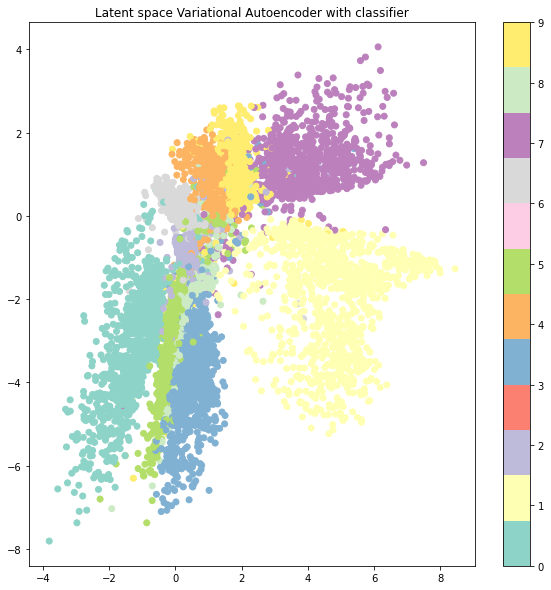

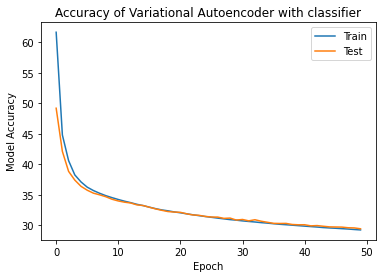

In [39]:
network_with_classifier = VAE(data_zoom)
network_with_classifier.build_encoder()
network_with_classifier.build_decoder()
network_with_classifier.build_classifier()
network_with_classifier.build_vae(use_latent_classifier=True)
network_with_classifier.fit_data(epochs = 50, use_latent_classifier=True)
network_with_classifier.dir()
network_with_classifier.plot_latent_dimension("Variational Autoencoder with classifier")
network_with_classifier.plot_score("Variational Autoencoder with classifier")
